In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import seaborn as sns
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [4]:
# report = ProfileReport(df)

In [5]:
# report

# Data Cleaning

Checking null values

In [6]:
df.nunique()

show_id         7787
type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

In [7]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

The missing values are in:
* `director`: not important for analysis
* `cast`: too many different values, can't extract valuable information
* `country`: important variable
* `date_added`: small quantity, drop rows
* `rating`: small quantity, drop rows

### Fix rating missings

In [8]:
df['rating'].unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [9]:
df[df['rating'].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
67,s68,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
2359,s2360,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
3660,s3661,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
3736,s3737,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
3737,s3738,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
3738,s3739,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...
4323,s4324,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


Based on the information from [Amazon](https://www.amazon.com/gp/help/customer/display.html?nodeId=G2C2CPZWGZWHZ42J) rating information and Netflix shows, we can find the following replacements

In [10]:
rating_replacements = {
    211: 'TV-14',
    2411: 'TV-14',
    3288: 'PG-13',
    4056: 'TV-G',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-14',
    5234: 'TV-14',
    6231: 'TV-Y'
}

for id, rate in rating_replacements.items():
    df.iloc[id, 8] = rate
    
df['rating'].isna().sum()

7

### Drop director and cast columns

In [11]:
df = df.drop(['director', 'cast'], axis=1)
df.columns

Index(['show_id', 'type', 'title', 'country', 'date_added', 'release_year',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

### Fix date_added missings 

In [12]:
df[df['date_added'].isna()]

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
258,s259,TV Show,A Young Doctor's Notebook and Other Stories,United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."
549,s550,TV Show,Anthony Bourdain: Parts Unknown,United States,NaN,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...
2263,s2264,TV Show,Frasier,United States,NaN,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...
2288,s2289,TV Show,Friends,United States,NaN,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...
2555,s2556,TV Show,Gunslinger Girl,Japan,NaN,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe..."
3374,s3375,TV Show,Kikoriki,NaN,NaN,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...
3492,s3493,TV Show,La Familia P. Luche,United States,NaN,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder..."
3946,s3947,TV Show,Maron,United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
5137,s5138,TV Show,Red vs. Blue,United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6065,s6066,TV Show,The Adventures of Figaro Pho,Australia,NaN,2015,TV-Y7,2 Seasons,"Kids' TV, TV Comedies","Imagine your worst fears, then multiply them: ..."


In [13]:
df = df[df['date_added'].notna()]

### Fix country missing values

In [14]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

### Check if data is cleaned

In [15]:
df.isna().sum()

show_id         0
type            0
title           0
country         0
date_added      0
release_year    0
rating          7
duration        0
listed_in       0
description     0
dtype: int64

## Generate new columns based on variables

In [16]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


### Year and month by adding date

We are going to take the year and the month from `date_added` so we can compare which months are the most valuable and the difference between Show release and Netflix date_added

In [17]:
df['year_added'] = df['date_added'].apply(lambda x: x.split(" ")[-1])
df['year_added'].head()

0    2020
1    2016
2    2018
3    2017
4    2020
Name: year_added, dtype: object

In [18]:
df['month_added'] = df['date_added'].apply(lambda x: x.split(" ")[0])
df['month_added'].head()

0      August
1    December
2    December
3    November
4     January
Name: month_added, dtype: object

### Shows targets based on rating

This could be interesting to show who production targets

In [19]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

In [20]:
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Adults', 'Teens', 'Older Kids', 'Kids', nan], dtype=object)

### Country fix

There are some entires where `country` has multiple values. We can fix that with a simple string split.

In [21]:
# Lets retrieve just the first country
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['principal_country'].head()

0           Brazil
1           Mexico
2        Singapore
3    United States
4    United States
Name: principal_country, dtype: object

## Fix data types

In [22]:
df.dtypes

show_id              object
type                 object
title                object
country              object
date_added           object
release_year          int64
rating               object
duration             object
listed_in            object
description          object
year_added           object
month_added          object
target_ages          object
principal_country    object
dtype: object

In [23]:
# type should be a category
df['type'] = pd.Categorical(df['type'])
# target_ages is another category (4 classes)
df['target_ages'] = pd.Categorical(df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

# Year added should be integer so we can compare with `released_year`
df['year_added'] = pd.to_numeric(df['year_added'])

In [24]:
df.dtypes

show_id                object
type                 category
title                  object
country                object
date_added             object
release_year            int64
rating                 object
duration               object
listed_in              object
description            object
year_added              int64
month_added            object
target_ages          category
principal_country      object
dtype: object

# Data Visualization

In [25]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,target_ages,principal_country
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,August,Adults,Brazil
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,December,Adults,Mexico
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,December,Adults,Singapore
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,November,Teens,United States
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,January,Teens,United States


In [26]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
df['genre'].head()

0    [International TV Shows, TV Dramas, TV Sci-Fi ...
1                       [Dramas, International Movies]
2                [Horror Movies, International Movies]
3    [Action & Adventure, Independent Movies, Sci-F...
4                                             [Dramas]
Name: genre, dtype: object

In [27]:
movie_df = df[df['type'] == 'Movie']
show_df = df[df['type'] == 'TV Show']

show_df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,target_ages,principal_country,genre
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,August,Adults,Brazil,"[International TV Shows, TV Dramas, TV Sci-Fi ..."
5,s6,TV Show,46,Turkey,"July 1, 2017",2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,2017,July,Adults,Turkey,"[International TV Shows, TV Dramas, TV Mysteries]"
11,s12,TV Show,1983,"Poland, United States","November 30, 2018",2018,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","In this dark alt-history thriller, a naïve law...",2018,November,Adults,Poland,"[Crime TV Shows, International TV Shows, TV Dr..."
12,s13,TV Show,1994,Mexico,"May 17, 2019",2019,TV-MA,1 Season,"Crime TV Shows, Docuseries, International TV S...",Archival video and new interviews examine Mexi...,2019,May,Adults,Mexico,"[Crime TV Shows, Docuseries, International TV ..."
16,s17,TV Show,Feb-09,United States,"March 20, 2019",2018,TV-14,1 Season,"International TV Shows, TV Dramas","As a psychology professor faces Alzheimer's, h...",2019,March,Teens,United States,"[International TV Shows, TV Dramas]"


As we can see, there are many more TV shows than Movies

In [28]:
fig = px.pie(df['type'].value_counts().reset_index(), values='type', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [29]:
def generate_rating_df(df):
    rating_df = df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['rating', 'target_ages', 'counts']
    rating_df = rating_df.sort_values('target_ages')
    return rating_df

In [30]:
rating_df = generate_rating_df(df)
fig = px.bar(rating_df, x='rating', y='counts', color='target_ages')
fig.show()

In [31]:
movie_rating_df = generate_rating_df(movie_df)
show_rating_df = generate_rating_df(show_df)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=movie_rating_df['target_ages'], values=movie_rating_df['counts']),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=show_rating_df['target_ages'], values=show_rating_df['counts']),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Rating distribution by Type of content",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Movies', x=0.16, y=0.5, font_size=12, showarrow=False),
                 dict(text='TV Shows', x=0.82, y=0.5, font_size=12, showarrow=False)])
fig.show()

In [32]:
country_df = df['principal_country'].value_counts().reset_index()
country_df = country_df[country_df['principal_country'] /  country_df['principal_country'].sum() > 0.01]

fig = px.pie(country_df, values='principal_country', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [33]:
fig = px.histogram(df, x='principal_country')
fig.update_xaxes(categoryorder='total descending')
fig.show()

# Distribution of content released

As we can see, in the last few years, there has been a increment in content productions

In [34]:
released_year_df = df.loc[df['release_year'] > 2010].groupby(['release_year', 'type']).agg({'show_id': 'count'}).reset_index()
added_year_df = df.loc[df['year_added'] > 2010].groupby(['year_added', 'type']).agg({'show_id': 'count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'Movie']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Released Year',
    marker_color='green',
))
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'TV Show']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Released Year',
    marker_color='darkgreen',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'Movie']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Year Added',
    marker_color='orange',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'TV Show']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Year Added',
    marker_color='darkorange',
))
fig.update_xaxes(categoryorder='total descending')
fig.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



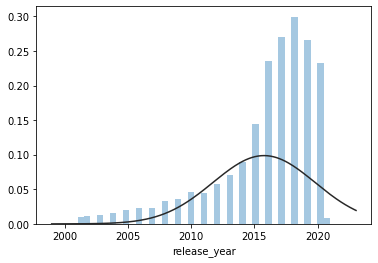

In [35]:
from scipy.stats import norm

sns.distplot(df.loc[df['release_year'] > 2000, 'release_year'], fit=norm, kde=False)

# Genres Analysis

### Build dataframes for `type`s of content

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer 

In [37]:
def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

In [38]:
def top_genres(df, title='Top ones'):
    genres_df = calculate_mlb(df['genre'])
    tdata = genres_df.sum().sort_values(ascending=False)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tdata.index,
        y=tdata.values,
    ))
    fig.update_xaxes(categoryorder='total descending')
    fig.update_layout(title=title)
    fig.show()

In [39]:
top_genres(movie_df, title='Top Movies Genres')

In [40]:
top_movies_genres = [
    'International Movies',
    'Dramas',
    'Comedies',
    'Documentaries',
    'Action & Adventure',
]

In [41]:
top_genres(show_df, title='Top TV Shows Genres')

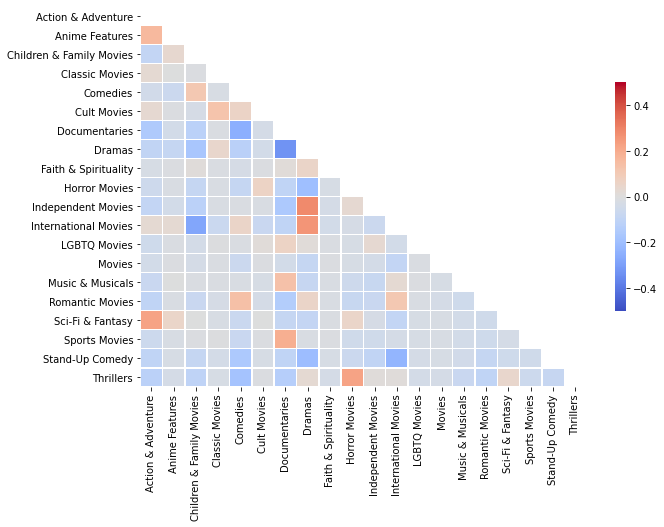

In [42]:
genres_df = calculate_mlb(movie_df['genre'])

movie_corr = genres_df.corr()
movie_mask = np.zeros_like(movie_corr, dtype=np.bool)
movie_mask[np.triu_indices_from(movie_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(movie_corr, mask=movie_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

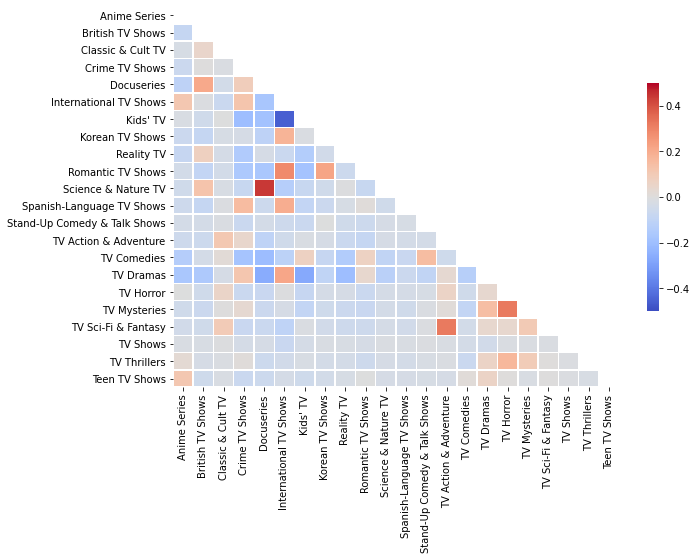

In [43]:
genres_df = calculate_mlb(show_df['genre'])

show_corr = genres_df.corr()
show_mask = np.zeros_like(show_corr, dtype=np.bool)
show_mask[np.triu_indices_from(show_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(show_corr, mask=show_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

# Duration analysis

### Analyze Series duration

This values are in term of seasons, so there is no much to analyze.

As we can see the most of the series are only **1 season** probably becasuse they were cancelled or they are new and the second one is in production.

In [44]:
fig = px.histogram(x=show_df['duration'])
fig.update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Distribution of shows duration",
    xaxis_title="Duration of the Show",
)
fig.show()

### Movie duration Alasysis

Lets split the data duration into bins:
- Less than 1.30 hours
- More than 1.30 hours and less than 2.30 hours
- More than 2.30 hours

As we can see, the most of the movies' **duration is between 1.30 hours and 2.30 hours**

In [45]:
temp_duration = movie_df['duration'].apply(lambda x: int(x.split(' ')[0]))

In [46]:
movie_df.loc[temp_duration.loc[temp_duration < 90].index, 'duration_bin'] = 'Less than 1.30 hours'
movie_df.loc[temp_duration.loc[(temp_duration >= 90) & (temp_duration < 150)].index, 'duration_bin'] = 'More than 1.30 - less than 2.30 hours'
movie_df.loc[temp_duration.loc[temp_duration >= 150].index, 'duration_bin'] = 'More than 2.30 hours'

In [47]:
movie_df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,target_ages,principal_country,genre,duration_bin
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,December,Adults,Mexico,"[Dramas, International Movies]",More than 1.30 - less than 2.30 hours
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,December,Adults,Singapore,"[Horror Movies, International Movies]",Less than 1.30 hours
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,November,Teens,United States,"[Action & Adventure, Independent Movies, Sci-F...",Less than 1.30 hours
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,January,Teens,United States,[Dramas],More than 1.30 - less than 2.30 hours
6,s7,Movie,122,Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",2020,June,Adults,Egypt,"[Horror Movies, International Movies]",More than 1.30 - less than 2.30 hours


In [48]:
fig = px.histogram(x=movie_df['duration_bin'], color=movie_df['duration_bin'])
fig.update_xaxes(categoryorder = "array",
                categoryarray = ['Less than 1.30 hours', 'More than 1.30 - less than 2.30 hours', 'More than 2.30 hours'],
                )
fig.update_layout(
    title="Distribution of movies duration",
    xaxis_title="Duration of the Movies",
)
fig.show()

# Top Genres release by year

As we saw in the previous step, in the last 4 years, there have been a large amount of shows releases. We will explore the distribution of genres by year.

I will be testing the new **sunburst** plot.

In [49]:
def check_genre_contains(genres):
    for genre in genres:
        if genre in top_movies_genres:
            return True
    return False

In [50]:
movie_df['principal_genre'] = movie_df['genre'].apply(lambda genres: genres[0])
movie_df['principal_genre'].head()

1                Dramas
2         Horror Movies
3    Action & Adventure
4                Dramas
6         Horror Movies
Name: principal_genre, dtype: object

In [51]:
year_genre_df = movie_df[(movie_df['principal_genre'].isin(top_movies_genres)) & (movie_df['year_added'] >= 2017)].groupby(['principal_genre', 'year_added']).agg({'title': 'count'})
year_genre_df = year_genre_df.reset_index()
year_genre_df.columns = ['principal_genre', 'year_added', 'count']

fig = px.sunburst(year_genre_df, path=['year_added', 'principal_genre'], values='count')
fig.show()